<a href="https://colab.research.google.com/github/yazuyuichiro/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow-2nd-Edition/blob/CHANET_WORK/%E3%80%90%E5%AE%9F%E8%B7%B5%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%80%9111_1_3_1_11_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

## 11.1.3.1： kerasによるバッチ正規化の実装

- 個々の隠れ層の活性化関数の前か後ろにBatchNormalization層を追加する
- オプションでモデルの最初の層としてもBatchNormalization層を追加することが可能

In [ ]:
# BatchNormalization層の実装（すべての隠れ層の後に配置した例）

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])



"""
テキストでは、バッチ正規化層を活性化関数の後においているが、バッチ正規化の論文を発表した著者たちは活性化関数の前に置くことを推奨している。
活性化関数の前か後ろかのどちらが良いかはタスクによって変わるのではないかというのがテキスト著者の見解。

活性化関数の後ろに持ってきた場合
model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
  keras.layers.BatchNormalization(),
  keras.layers.Activation("elu"),
  keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
  keras.layers.BatchNormalization(),
  keras.layers.Activation("elu"),
  keras.layers.Dense(10, activation="softmax),
])
"""

In [ ]:
# モデルのsummary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [ ]:
# BN層のパラメータを確認
[(var.name, var.trainable) for var in model.layers[1].variables]

# moving_meanとmoving_varianceは移動平均であり、バックプロパゲーションの影響を受けないので、Kerasは「学習不能」と呼んでいる。

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [ ]:
# 【再掲】BatchNormalization層の実装

"""
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])



# BatchNormalizationクラスには調整できるハイパーパラメータが多くある。通常はデフォルトでうまく機能するが、
・momentum
・axis（デフォルトは-1）
の2つは調整の点で重要なものとしてあがっている。
"""

## 11.1.4: 勾配クリッピング

- 勾配爆発対策として、単純にバックプロパゲーションで勾配をクリッピングし一定の閾値を超えないようにする方法
- 通常、BatchNormalizationがあれば必要ないが、BatchNormalizationが使いにくい再帰型ニューラルネットワークにおいて最も多用される（詳細は15章）

Kerasではオプティマイザを作るときにclipvalueかclipnormのどちらかの引数を設定するだけで実装できる

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss='mse', optimizer=optimizer)

"""
損失のすべての偏微分（すべての訓練可能なパラメータについて）が、-1.0から1.0におさまるようにクリッピングされる。
ex) 勾配ベクトル[0.9, 100.0] →　[0.9, 1.0]
      この例のようにベクトルの向きが変わることがあるが、実際にはこのアプローチはうまく機能する

向きを変えたくないときは、l2ノルムを考慮してクリッピングを行う、clipnormを使用する。
ex) clipnorm=1.0のとき、勾配ベクトル[0.9, 100.0] → [0.00899964, 0.9999595]

訓練中に勾配爆発が見られる場合は、閾値を変えながら、両方を試してみると良い。
"""

## 11.2: 事前学習済みの層の再利用

### 転移学習

事前学習されたDNNのタスクと似ているほど、再利用したい層の数は（下位層から数えて）増える。

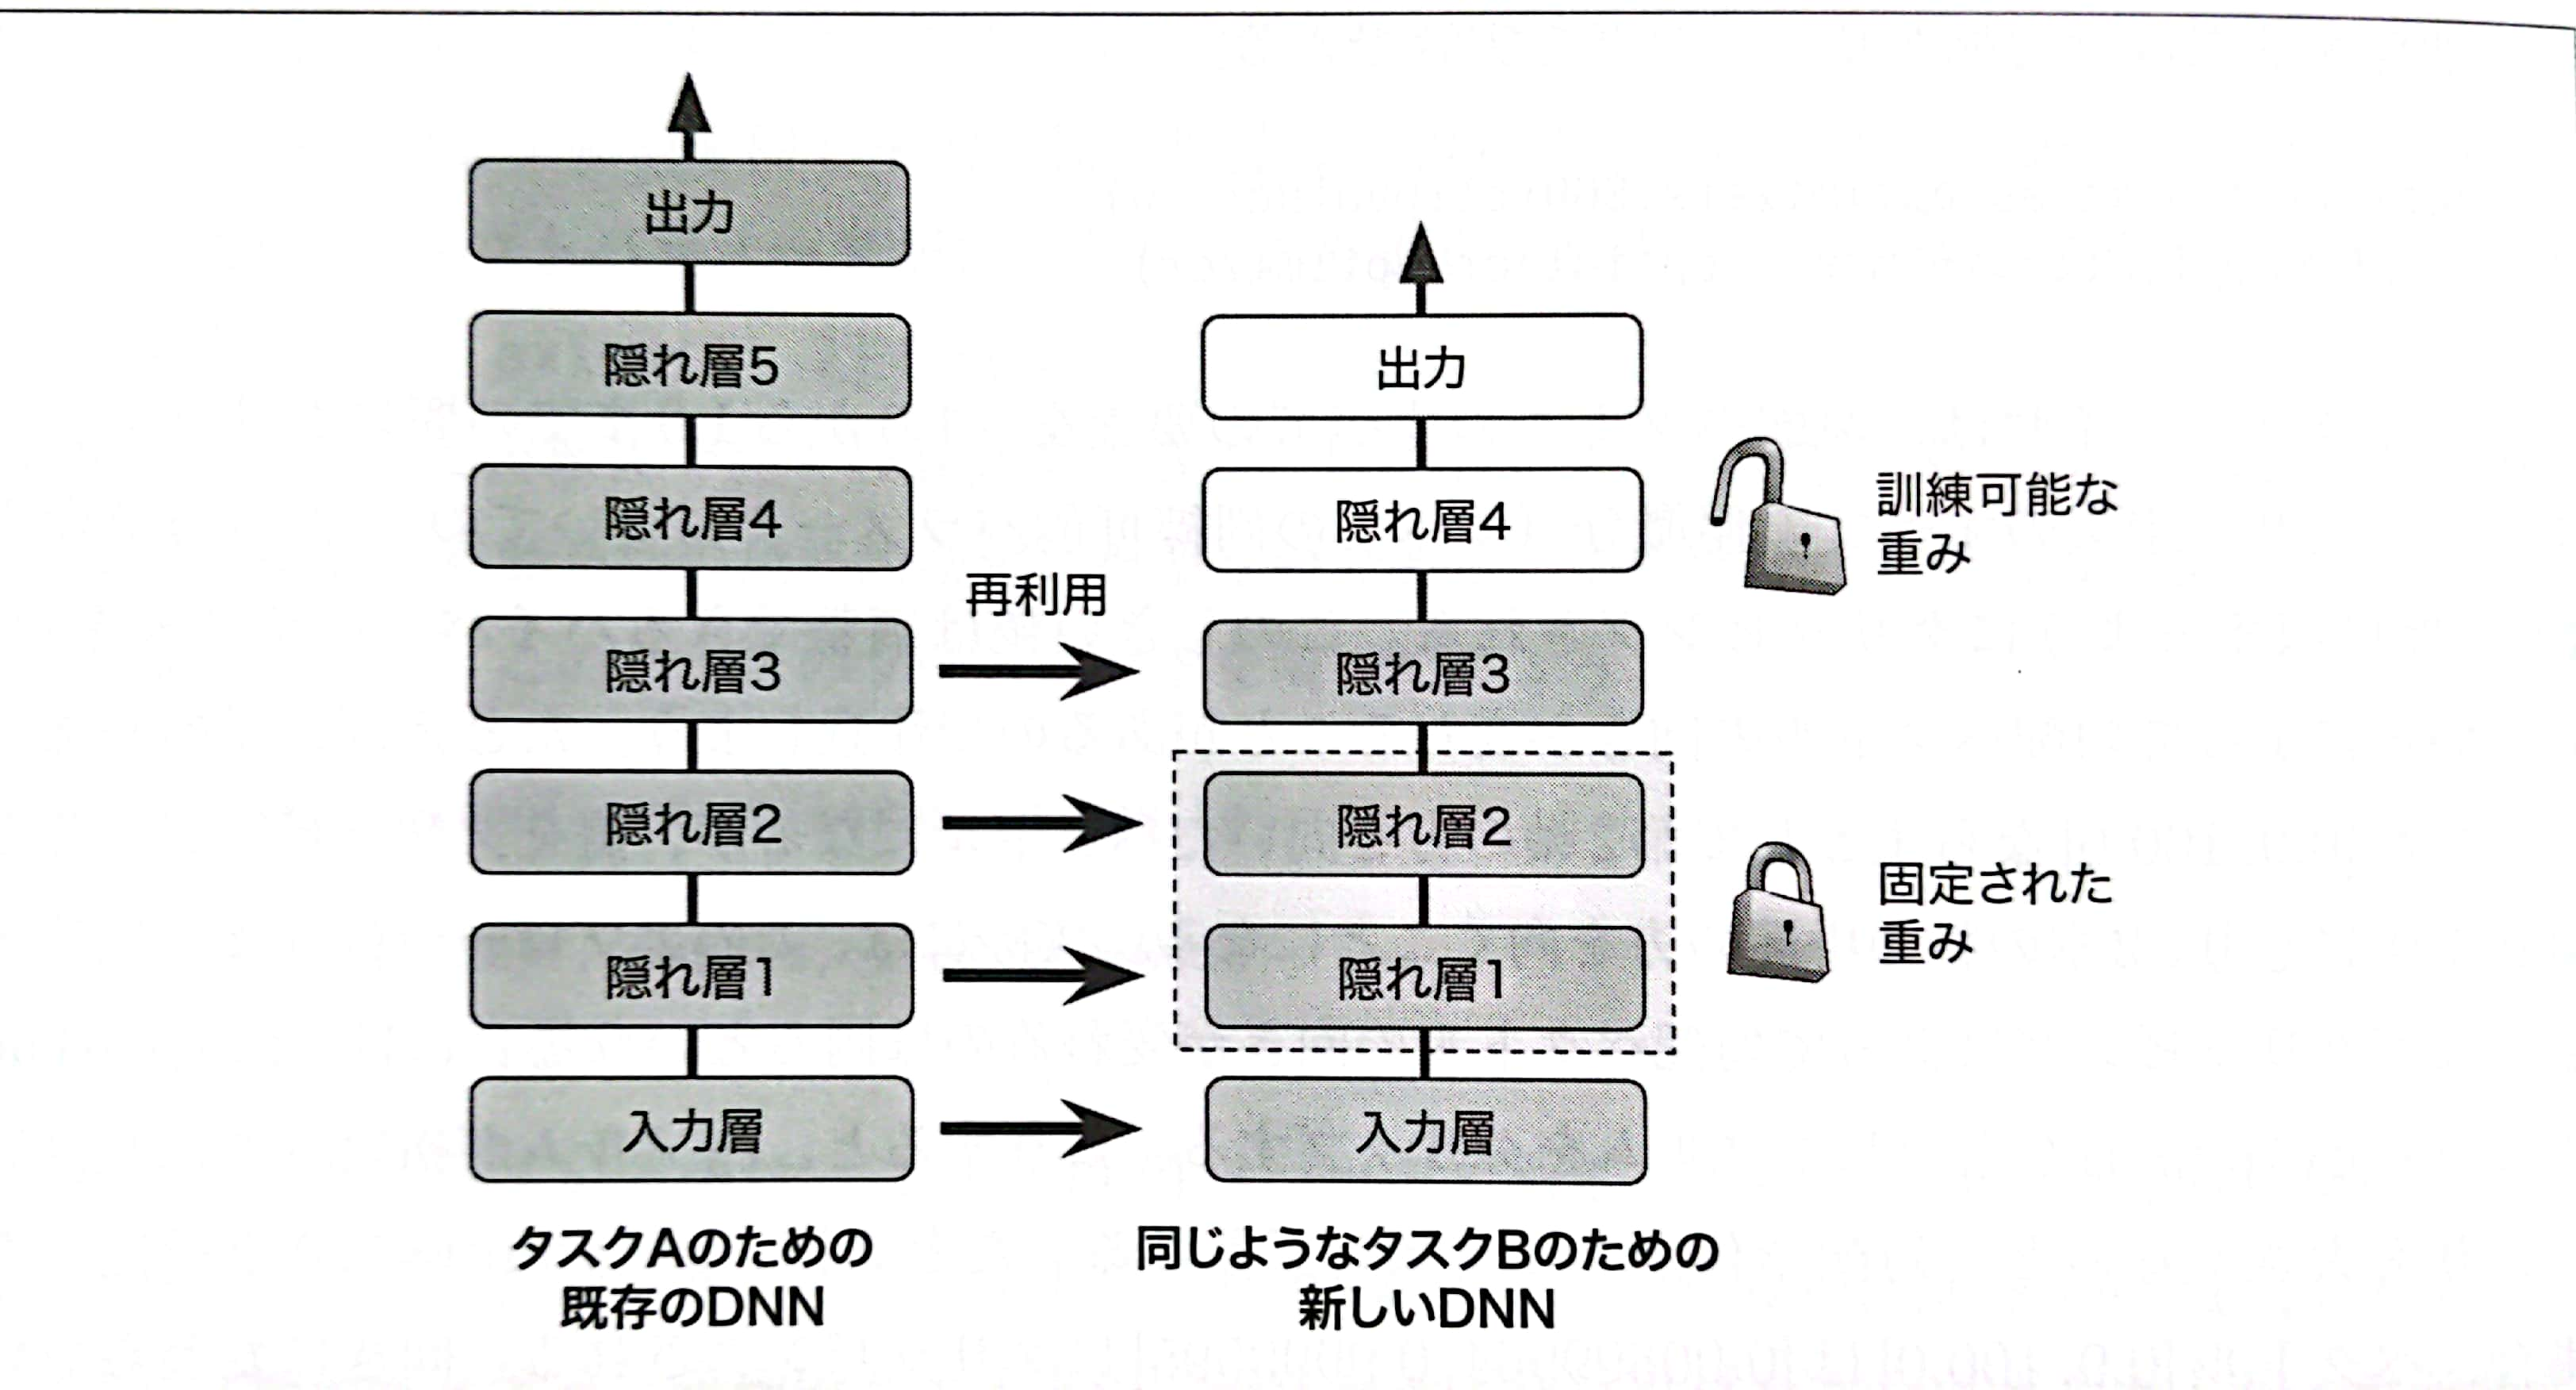

転移学習の手順

1. 再利用の層を凍結し、重みを訓練不能にすることで、勾配降下法で重みが更新されないようにする
2. モデルを訓練して性能をみる
3. 次に、上位の1, 2個の層の凍結を解除して、重み更新を許し、性能が向上するかどうかをみる
    （訓練データが多いほど凍結を解除できる層が増える）
4. それでもよい性能が得られず、訓練データが少ない場合には、上位の隠れ層を捨て、残りの隠れ層を再び凍結し、再利用できる層の数がわかるまで繰り返す。訓練データが多い場合には、上位の層を捨てるのではなく、交換したり、隠れそうを増やしたりしてみてよい

※再利用の層の凍結を解除するときは、学習率を下げると、細かく調整した重みが覆るのを防ぐことができる。

## 11.2.1: Kerasによる転移学習・ファインチューニング

場面設定　　

Fashion MNISTデータセットは本来、ズボンやコートなど10クラスあるが、ここではサンダルとシャツを除く8種類のクラスしか含まれていないとする。誰かがそのデータセットを使って、モデルAを作って公開している。いま私の手元にはサンダルとシャツの画像があり、それを使って二項分類器（陽性はシャツ、陰性はサンダル）を訓練したい。しかしデータセットは小規模で、ラベル付き画像が200件しかない。モデルAのアーキテクチャでこのタスクのための新モデル（モデルB）を訓練してみたところ、まずまずの性能が得られた（正解率97.2％）。しかし、これは簡単なタスクであり、もっと性能を求めたい。このタスクはタスクAと似ているので転移学習が役に立つのではないかと考えている。

In [ ]:
# モデルAをロードし、その層に基づいて新モデルを作る。（ここでは出力層以外のすべての層を再利用）

model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))



"""
model_Aとmodel_B_on_Aは同じ層を共有している。model_B_on_Aを訓練すると、model_Aにも影響が及ぶ。それを避けたければ、以下のようにcloneを作れば良い。

model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
"""

In [ ]:
"""
これでmodel_B_on_Aを訓練できるようになったが、新しい出力層は無作為に初期化されているので、
少なくとも最初の数エポックのうちは大きな誤差を生むと考えられる。
その誤差により再利用した重みが壊されてしまうのを防ぐため、たとえば最初の数エポックのうちは再利用した層を凍結する方法がある。
"""

# すべての層のtrainable属性をFalseにしてモデルをコンパイルする

for layer in model_B_on_A.layers[:-1]:
  layer.trainable = False

model_B_on_A,compile(loss="binary_crossentropy", optimizer="sgd",
                     metrics=['accuracy'])

"""
層を凍結したり凍結解除したりするときは必ずモデルをコンパイルしなければならない
"""

In [ ]:
# 数エポック訓練後、再利用の層の凍結を解除し、訓練を続ける

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
  layer.trainable = True

optimizer = keras.optimizers.SGD(lr=1e-4) # デフォルトは1e-2
model_B_on_A.compile(loss='binary_crossentropy', optimizer=optimizer,
                     metrics=['accurary'])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

"""
方法は以上となる。
ただし、小規模な全結合ネットワークでは転移学習はあまりいまくいかないことが知られている。
転移学習の詳細は14章に譲る。
"""

### 11.2.2: 教師なし事前学習

ラベル付きの訓練データがあまりない上、似たタスクで訓練されたモデルも見つからず、ラベル付き訓練データを集めることも難しい場合でも、教師なし事前学習が使える場合がある。

ラベルなしの訓練データであればたくさん集められる場合、それを使ってオートエンコーダや敵対的生成ネットワークなどの教師なしモデル（17章参照）を訓練してみるとよい。そして、オートエンコーダの下位層やGANの判別器の下位層を再利用し、目的のタスクに合わせた出力層を最上位に追加する。そして、手元のラベル付き訓練データを用いて、教師あり学習で最終的なネットワークを微調整する。

### オートエンコーダで学習する例


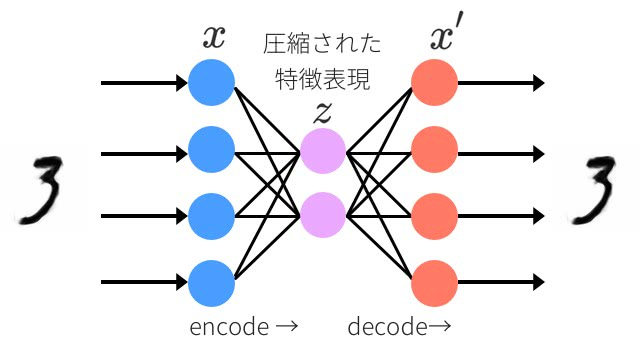

In [19]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
# fashionMNISTのデータ準備
fashion_mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() # train_images.shape: (60000, 28, 28), test_images.shape: (10000, 28, 28)

# 正規化（Min-Max normalization）
train_images = (train_images - train_images.min()) / (train_images.max() - train_images.min())
test_images = (test_images - test_images.min()) / (test_images.max() - test_images.min())

# 次元の調整
image_height, image_width = 28, 28
train_images = train_images.reshape(train_images.shape[0], (image_height*image_width))
test_images = test_images.reshape(test_images.shape[0], (image_height*image_width))

print("train_images.shape:", train_images.shape)
print("test_images.shape:", test_images.shape)

train_images.shape: (60000, 784)
test_images.shape: (10000, 784)


In [21]:
# オートエンコーダの作成
model = keras.models.Sequential([
    keras.layers.Dense(36, activation='relu', input_shape=(image_height*image_width,)),
    keras.layers.Dense(image_height*image_width, activation="sigmoid")
])

model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 36)                28260     
                                                                 
 dense_3 (Dense)             (None, 784)               29008     
                                                                 
Total params: 57,268
Trainable params: 57,268
Non-trainable params: 0
_________________________________________________________________


In [22]:
# オートエンコーダの学習
el_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss',
                            patience=5,
                            mode='min')
]

history = model.fit(train_images, train_images,
          epochs=200, batch_size=2024,
          shuffle=True,
          validation_data=(test_images, test_images),
          callbacks=el_callbacks
          )

Epoch 1/200
30/30 [==============================] - 1s 15ms/step - loss: 0.5344 - val_loss: 0.3277
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2905 - val_loss: 0.2686
Epoch 3/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2561 - val_loss: 0.2409
Epoch 4/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2311 - val_loss: 0.2189
Epoch 5/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2118 - val_loss: 0.2025
Epoch 6/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1982 - val_loss: 0.1912
Epoch 7/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1883 - val_loss: 0.1826
Epoch 8/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1804 - val_loss: 0.1755
Epoch 9/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1737 - val_loss: 0.1692
Epoch 10/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1677 - val_loss: 0.1635
Epo

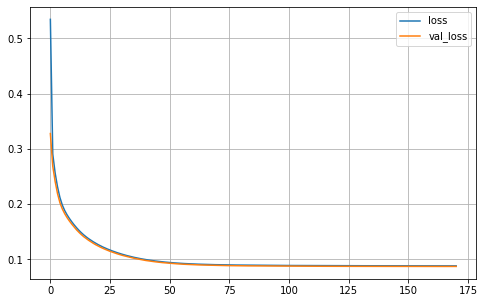

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

## 11.2.3: 関連タスクの事前学習

ラベル付きの訓練データがあまりないときの最終手段として、簡単にラベル付き訓練データを入手または生成できる補助タスクのために第一のニューラルネットワークを訓練してから、実際のタスクでそのネットワークの下位層を再利用する方法がある。

例）顔を認識するシステムを作りたい。個々人の写真は少なく、優れた分類器をつくることができない。ネット上の様々な人が写っている写真を大量に集め、2枚の異なる写真に同じ人が写っているかどうかを検出する第一段階のニューラルネットワークを訓練することはできる。そのようなネットワークは優れた顔の特徴検出器になるだろうし、その下位層を使えば、少数の訓練データで優れた顔分類器を訓練できる可能性がある。